In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class NonStationaryBandit:
    def __init__(self, k = 10, initial_mean = 0.9,walk_std = 0.01, seed  = 42):
        self.k = k
        self.walk_std = walk_std
        self.rng = np.random.default_rng(seed)

        self.q_star = np.ones(k) * initial_mean

    def step(self, action):
        """
        1) Get reward from the chosen action (normal around q_star[action], std=1).
        2) Random-walk update: each arm's q_star[a] <- q_star[a] + N(0, walk_std).
        3) Return the sampled reward.
        """
        reward = self.rng.normal(self.q_star[action], 1.0)

        # update true values by random walk increments
        increments = self.rng.normal(0.0, self.walk_std, size = self.k)
        self.q_star += increments
        return reward


In [3]:
class StationaryBandit:
    """
    A stationary k-armed bandit environment (for simpler tests).
    Each arm has a fixed mean (normal distribution, std=1 by default).
    """
    def __init__(self, means, seed=42):
        self.means = np.array(means)
        self.k = len(means)
        self.rng = np.random.default_rng(seed)

    def step(self, action):
        return self.rng.normal(self.means[action], 1.0)

In [4]:
from estimators import SampleAverageEstimator, ExponentialRecencyWeightedAverageEstimator 
# different name for constant step estimator
from actors import EpsilonGreedyActor, UCBActor
from agents import ActionValueBanditAgent

In [6]:
def run_bandit(agent, env, steps=1000):
    """
    Run a single bandit trial for 'steps' timesteps.
    Returns an array of rewards of shape (steps,).
    """
    rewards = np.zeros(steps)
    for t in range(steps):
        action = agent.action() # get an integer for the bandit to pull
        reward = env.step(action) # get the reward for that action
        agent.update(action, reward) # the estimate corresponding to the bandit is updated with the reward
        rewards[t] = reward # reward received at time step t
    # print(f"Total reward: {rewards.sum()}")
    # print(f"Optimal reward: {np.max(env.means)*steps}")
    return rewards

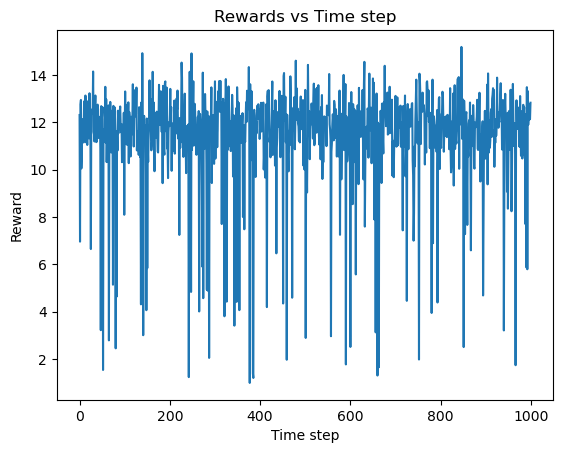

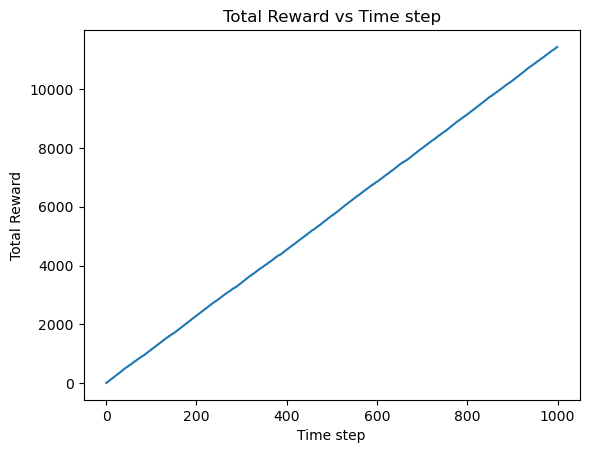

In [7]:
# test the run_bandit function
estimator_list = [SampleAverageEstimator(Q1=0.0) for _ in range(10)]
actor = EpsilonGreedyActor(k = 10, epsilon=0.1)
agent = ActionValueBanditAgent(estimator_list, actor)
means = [12,2,3,5,4,7,8,6,9,10]
my_env = StationaryBandit(means)
rewards = run_bandit(agent, my_env, steps=1000)
# plot of rewards vs time step
plt.plot(rewards)
plt.xlabel('Time step')
plt.ylabel('Reward')
plt.title('Rewards vs Time step')
plt.show()
# plot total reward over time
total_reward = np.cumsum(rewards)
plt.plot(total_reward)
plt.xlabel('Time step')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Time step')
plt.show()

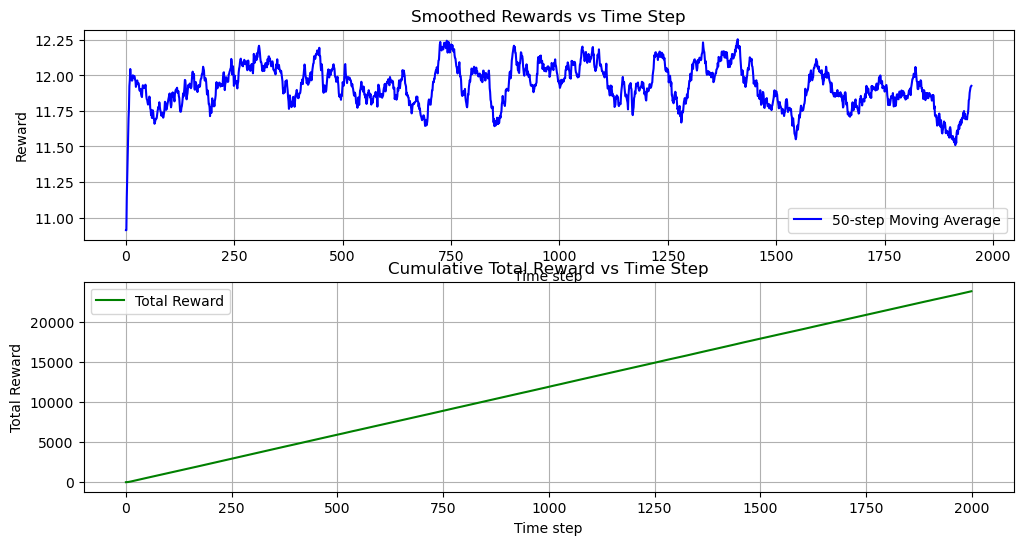

In [8]:
estimator_list = [SampleAverageEstimator(Q1=0.0) for _ in range(10)]
actor = UCBActor(k = 10, c=2)
agent = ActionValueBanditAgent(estimator_list, actor)
means = [12,2,3,5,4,7,8,6,9,10]
my_env = StationaryBandit(means)
rewards = run_bandit(agent, my_env, steps=2000)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Plot settings
window_size = 50  # Moving average window size

# Plot raw rewards with smoothing
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
smoothed_rewards = moving_average(rewards, window_size)
plt.plot(smoothed_rewards, label=f'{window_size}-step Moving Average', color='blue')
plt.xlabel('Time step')
plt.ylabel('Reward')
plt.title('Smoothed Rewards vs Time Step')
plt.grid(True)
plt.legend()

# Plot cumulative total reward
plt.subplot(2, 1, 2)
total_reward = np.cumsum(rewards)
plt.plot(total_reward, label='Total Reward', color='green')
plt.xlabel('Time step')
plt.ylabel('Total Reward')
plt.title('Cumulative Total Reward vs Time Step')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
def average_rewards_over_runs(agent_builder, env_builder, steps=1000, runs=200) -> np.ndarray:
    """
    Repeats the environment+agent interaction for multiple runs
    to get average performance.
    - agent_builder(): function that returns a fresh agent
    - env_builder(): function that returns a fresh environment
    """
    all_rewards = np.zeros((runs, steps)) # 2D array to store for each run the rewards at each time step
    for r in range(runs):
        agent = agent_builder()
        env = env_builder()
        rewards = run_bandit(agent, env, steps)
        all_rewards[r, :] = rewards # for run r, store the rewards at each time step
    avg_rewards = np.mean(all_rewards, axis=0) # average over all runs for each time step, axis = 0, so for each time step, you take average rewards
    return avg_rewards

In [10]:
def experiment_epsilons_stationary():
    k = 10
    steps = 1000
    runs = 200

    means = np.random.normal(0, 1, k)  # random means for each arm
    env_builder = lambda: StationaryBandit(means=means, seed=None)  # random seed each run

    plt.figure(figsize=(8, 6))
    eps_values = [0.0, 0.01, 0.1, 0.2]
    for eps in eps_values:
        def agent_builder():
            estimators = [SampleAverageEstimator(Q1=0.0) for _ in range(k)]
            actor = EpsilonGreedyActor(k, epsilon=eps, seed=None) # different epsilon for each experiment
            return ActionValueBanditAgent(estimators, actor)

        avg_rewards = average_rewards_over_runs(agent_builder, env_builder, steps=steps, runs=runs)
        plt.plot(avg_rewards, label=f'eps={eps}')

    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title('Stationary 10-armed Bandit: Epsilon-Greedy')
    plt.legend()
    plt.show()


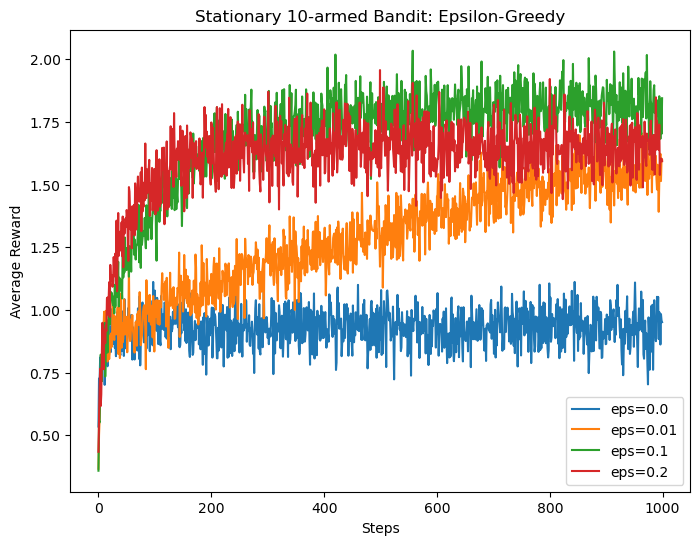

In [11]:
experiment_epsilons_stationary()

In [12]:
def experiment_epsilons_stationary_2():
    k = 10
    steps = 1000
    runs = 200

    # Random means for each arm
    means = np.random.normal(0, 1, k)
    env_builder = lambda: StationaryBandit(means=means, seed=None)  # Random seed for each run

    plt.figure(figsize=(10, 7))
    eps_values = [0.0, 0.01, 0.1, 0.2]
    for eps in eps_values:
        def agent_builder():
            estimators = [SampleAverageEstimator(Q1=0.0) for _ in range(k)]
            actor = EpsilonGreedyActor(k, epsilon=eps, seed=None)  # Different epsilon for each experiment
            return ActionValueBanditAgent(estimators, actor)

        # Collect average rewards over runs
        avg_rewards, std_rewards = average_rewards_over_runs_with_std(agent_builder, env_builder, steps=steps, runs=runs)
        
        # Moving average for smooth curves
        window_size = 50
        smoothed_rewards = np.convolve(avg_rewards, np.ones(window_size) / window_size, mode='valid')
        smoothed_std = np.convolve(std_rewards, np.ones(window_size) / window_size, mode='valid')

        # Plot with confidence interval
        steps_range = np.arange(len(smoothed_rewards))
        plt.plot(steps_range, smoothed_rewards, label=f'eps={eps}')
        plt.fill_between(
            steps_range,
            smoothed_rewards - smoothed_std,
            smoothed_rewards + smoothed_std,
            alpha=0.2
        )

    # Customize plot
    plt.xlabel('Steps', fontsize=12)
    plt.ylabel('Average Reward', fontsize=12)
    plt.title('Stationary 10-armed Bandit: Epsilon-Greedy', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def average_rewards_over_runs_with_std(agent_builder, env_builder, steps, runs):
    """Computes average rewards and standard deviation across multiple runs."""
    rewards = np.zeros((runs, steps))
    for run in range(runs):
        agent = agent_builder()
        env = env_builder()
        rewards[run] = run_bandit(agent, env, steps)
    avg_rewards = np.mean(rewards, axis=0)
    std_rewards = np.std(rewards, axis=0) / np.sqrt(runs)  # Standard error
    return avg_rewards, std_rewards


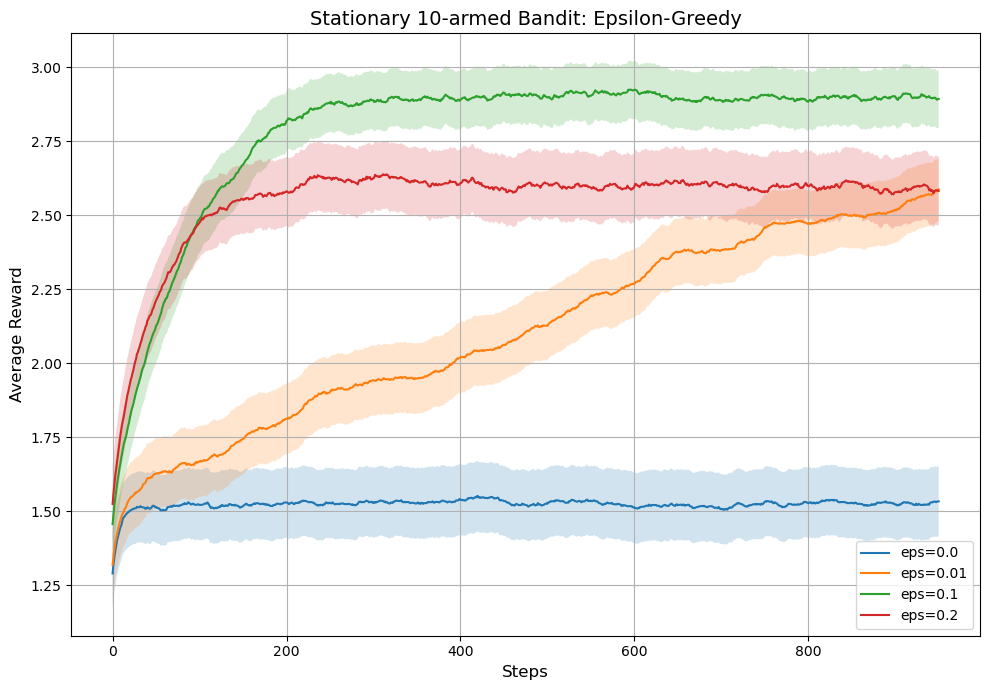

In [13]:
experiment_epsilons_stationary_2()

In [14]:
def experiment_ucb_stationary():
    k = 10
    steps = 1000
    runs = 200

    means = np.random.normal(0, 1, k)  # random means for each arm
    env_builder = lambda: StationaryBandit(means=means, seed=None)

    plt.figure(figsize=(8, 6))
    c_values = [0.1, 1, 2, 5]
    for c in c_values:
        def agent_builder():
            estimators = [SampleAverageEstimator(Q1=0.0) for _ in range(k)]
            actor = UCBActor(k, c=c)
            return ActionValueBanditAgent(estimators, actor)

        avg_rewards = average_rewards_over_runs(agent_builder, env_builder, steps=steps, runs=runs)
        plt.plot(avg_rewards, label=f'c={c}')

    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title('Stationary 10-armed Bandit: UCB for Different c')
    plt.legend()
    plt.show()

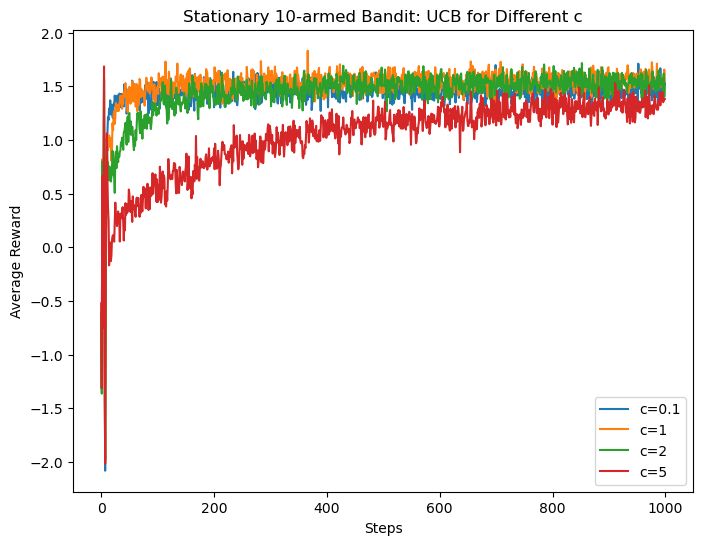

In [15]:
experiment_ucb_stationary() 

In [22]:
def run_nonstationary_bandit(agent_builder, env_builder, steps=10000, runs=200):
    """
    Runs a non-stationary k-armed bandit experiment multiple times.
    Tracks how often the agent picks the current best action.
    
    Returns:
      avg_optimal_action (np.ndarray): shape (steps,),
          the average % of times the best arm was chosen at each step
          (averaged across 'runs').
    """

    all_optimal = np.zeros((runs, steps), dtype=float)  # 1 if agent picked best arm, else 0

    for r in range(runs):
        agent = agent_builder()
        env = env_builder()
        for t in range(steps):
            # Agent picks an action
            action = agent.action()

            # Identify the best (true) arm in the environment right now
            best_action = np.argmax(env.q_star)

            # Record whether agent matched the best action
            if action == best_action:
                all_optimal[r, t] = 1.0
            else:
                all_optimal[r, t] = 0.0

            # Take environment step & update the agent with the reward
            reward = env.step(action)
            agent.update(action, reward)

    # Average over runs (axis=0)
    avg_optimal_action = np.mean(all_optimal, axis=0)  # shape (steps,)
    return avg_optimal_action


def experiment_nonstationary_epsilon():
    """
    Demonstration:
    - Compare Sample-Average vs Constant Step-Size (alpha=0.1),
      both with epsilon=0.1 in a non-stationary bandit
    - Plot fraction of optimal actions over time (200 runs, 10,000 steps).
    """

    k = 10
    steps = 10000
    runs = 200

    # 1) Environment builder (random walk with std=0.01)
    def env_builder():
        return NonStationaryBandit(k=k, initial_mean=0.0, walk_std=0.01, seed=None)

    # 2) Agents
    def agent_builder_sampleavg():
        estimators = [SampleAverageEstimator(Q1=0.0) for _ in range(k)]
        actor = EpsilonGreedyActor(k=k, epsilon=0.1, seed=None)
        return ActionValueBanditAgent(estimators, actor)

    def agent_builder_const():
        estimators = [ExponentialRecencyWeightedAverageEstimator(alpha=0.1, Q1=0.0) for _ in range(k)]
        actor = EpsilonGreedyActor(k=k, epsilon=0.1, seed=None)
        return ActionValueBanditAgent(estimators, actor)

    # 3) Collect fraction-of-optimal data over runs
    frac_opt_sample = run_nonstationary_bandit(agent_builder_sampleavg, env_builder, steps, runs)
    frac_opt_const  = run_nonstationary_bandit(agent_builder_const,     env_builder, steps, runs)

    # 4) Optionally take a cumulative average to visualize like "expanding().mean()" 
    #    or plot directly. We'll do a simple plot of fraction at each step.

    plt.figure(figsize=(10, 6))
    plt.plot(frac_opt_sample, label='Sample Avg, eps=0.1')
    plt.plot(frac_opt_const,  label='Constant Step=0.1, eps=0.1')
    plt.xlabel('Steps')
    plt.ylabel('Fraction of Optimal Actions')
    plt.title('Non-Stationary 10-Armed Bandit: % Optimal Action Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


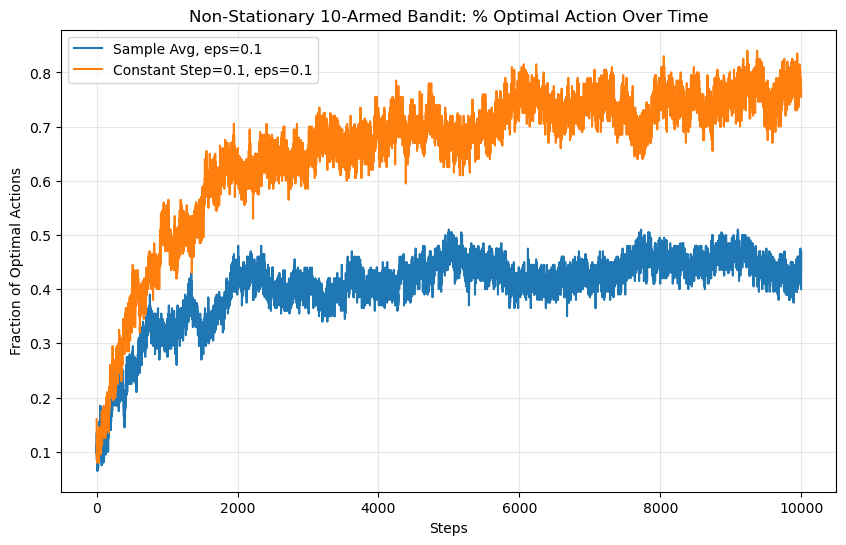

In [23]:
experiment_nonstationary_epsilon()